In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11156237293356258214, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9234857329
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14134436830529241888
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
from sklearn.metrics import log_loss
import sys
import time
import math
import os
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.regularizers import l2, l1

from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

import matplotlib.pyplot as plt
from keras.layers import Input, concatenate
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense

%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0


In [5]:
# print(os.listdir(""))

In [6]:
batch_size = 512
img_height, img_width = 128, 128
input_shape = (img_height, img_width, 3)
epochs = 1000

In [7]:
train_dir = 'data/train/'
test_dir = 'data/test'

In [8]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    validation_split= 0.2,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 319152 images belonging to 6 classes.
Found 79784 images belonging to 6 classes.
Found 13578 images belonging to 6 classes.


In [10]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 319152
nb_validation_samples: 79784
nb_test_samples: 13578

predict_size_train: 624
predict_size_validation: 156
predict_size_test: 27

 num_classes: 6


In [11]:
# os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "DenseNet201"

In [12]:
# vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
# vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
# resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
# nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
# nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
# mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"
# xception_weights = "../input/full-keras-pretrained-no-top/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [13]:
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet

In [ ]:
# input_tensor = Input(shape = input_shape)  

# base_model1=InceptionV3(input_shape= input_shape,weights=inception_weights, include_top=False, input_tensor=input_tensor)
# base_model2=Xception(input_shape= input_shape,weights=xception_weights, include_top=False, input_tensor=input_tensor)

# x1 = base_model1.output
# x1 = GlobalAveragePooling2D()(x1)

# x2 = base_model2.output
# x2 = GlobalAveragePooling2D()(x2)

# merge = concatenate([x1, x2])
# predictions = Dense(num_classes, activation='softmax')(merge)

# model = Model(inputs=input_tensor,outputs=predictions)

In [ ]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [ ]:
# c1 = model.layers[11].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[21].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[28].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[51].output
# c4 = GlobalAveragePooling2D()(c4) 

# c5 = model.layers[84].output
# c5 = GlobalAveragePooling2D()(c5) 

# c6 = model.layers[103].output
# c6 = GlobalAveragePooling2D()(c6) 

# c7 = model.layers[117].output
# c7 = GlobalAveragePooling2D()(c7) 

# c8 = model.layers[129].output
# c8 = GlobalAveragePooling2D()(c8) 

# c9 = model.layers[143].output
# c9 = GlobalAveragePooling2D()(c9) 

# c10 = model.layers[162].output
# c10 = GlobalAveragePooling2D()(c10) 

# c11 = model.layers[210].output
# c11 = GlobalAveragePooling2D()(c11) 

# c12 = model.layers[258].output
# c12 = GlobalAveragePooling2D()(c12) 

# c13 = model.layers[306].output
# c13 = GlobalAveragePooling2D()(c13) 

# c14 = model.layers[356].output
# c14 = GlobalAveragePooling2D()(c14) 

# c15 = model.layers[377].output
# c15 = GlobalAveragePooling2D()(c15) 

# c16 = model.layers[415].output
# c16 = GlobalAveragePooling2D()(c16) 

# c17 = model.layers[421].output
# c17 = GlobalAveragePooling2D()(c17) 

# con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [14]:
model = DenseNet201(weights="imagenet", include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

In [15]:
bottleneck_final_model = model

In [16]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [17]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [18]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [19]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))

# reset_keras_tf_session()

In [20]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [21]:
# dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(2048, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.25))

model.add(Dense(256, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.5))
    
model.add(Dense(num_classes, activation="softmax"))

adam_opt=Adam(lr = 0.0001, beta_1=0.8, beta_2=0.99)

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=1000,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 319152 samples, validate on 79784 samples
Epoch 1/1000
 - 10s - loss: 0.8005 - acc: 0.7356 - val_loss: 0.5726 - val_acc: 0.8229
Epoch 2/1000
 - 7s - loss: 0.5579 - acc: 0.8214 - val_loss: 0.4924 - val_acc: 0.8483
Epoch 3/1000
 - 7s - loss: 0.4995 - acc: 0.8399 - val_loss: 0.4565 - val_acc: 0.8587
Epoch 4/1000
 - 7s - loss: 0.4656 - acc: 0.8509 - val_loss: 0.4323 - val_acc: 0.8652
Epoch 5/1000
 - 7s - loss: 0.4458 - acc: 0.8569 - val_loss: 0.4153 - val_acc: 0.8705
Epoch 6/1000
 - 7s - loss: 0.4291 - acc: 0.8622 - val_loss: 0.4033 - val_acc: 0.8723
Epoch 7/1000
 - 7s - loss: 0.4174 - acc: 0.8661 - val_loss: 0.3958 - val_acc: 0.8734
Epoch 8/1000
 - 7s - loss: 0.4076 - acc: 0.8685 - val_loss: 0.3892 - val_acc: 0.8776
Epoch 9/1000
 - 7s - loss: 0.3988 - acc: 0.8714 - val_loss: 0.3756 - val_acc: 0.8813
Epoch 10/1000
 - 7s - loss: 0.3921 - acc: 0.8740 - val_loss: 0.3693 - val_acc: 0.8842
Epoch 11/1000
 - 7s - loss: 0.3852 - acc: 0.8762 - val_loss: 0.3622 - val_acc: 0.8858
Epoch 12/10

Epoch 96/1000
 - 7s - loss: 0.2758 - acc: 0.9181 - val_loss: 0.2588 - val_acc: 0.9241
Epoch 97/1000
 - 7s - loss: 0.2769 - acc: 0.9179 - val_loss: 0.2576 - val_acc: 0.9250
Epoch 98/1000
 - 7s - loss: 0.2760 - acc: 0.9182 - val_loss: 0.2584 - val_acc: 0.9260
Epoch 99/1000
 - 7s - loss: 0.2758 - acc: 0.9177 - val_loss: 0.2564 - val_acc: 0.9256
Epoch 100/1000
 - 7s - loss: 0.2753 - acc: 0.9189 - val_loss: 0.2612 - val_acc: 0.9236
Epoch 101/1000
 - 7s - loss: 0.2748 - acc: 0.9188 - val_loss: 0.2621 - val_acc: 0.9233
Epoch 102/1000
 - 7s - loss: 0.2745 - acc: 0.9187 - val_loss: 0.2570 - val_acc: 0.9273
Epoch 103/1000
 - 7s - loss: 0.2748 - acc: 0.9189 - val_loss: 0.2569 - val_acc: 0.9247
Epoch 104/1000
 - 7s - loss: 0.2739 - acc: 0.9193 - val_loss: 0.2566 - val_acc: 0.9258
Epoch 105/1000
 - 7s - loss: 0.2743 - acc: 0.9189 - val_loss: 0.2568 - val_acc: 0.9263
Epoch 106/1000
 - 7s - loss: 0.2729 - acc: 0.9198 - val_loss: 0.2543 - val_acc: 0.9265
Epoch 107/1000
 - 7s - loss: 0.2730 - acc: 0.91

Epoch 191/1000
 - 7s - loss: 0.2578 - acc: 0.9267 - val_loss: 0.2393 - val_acc: 0.9349
Epoch 192/1000
 - 7s - loss: 0.2570 - acc: 0.9271 - val_loss: 0.2406 - val_acc: 0.9337
Epoch 193/1000
 - 7s - loss: 0.2573 - acc: 0.9268 - val_loss: 0.2381 - val_acc: 0.9350
Epoch 194/1000
 - 7s - loss: 0.2577 - acc: 0.9266 - val_loss: 0.2386 - val_acc: 0.9346
Epoch 195/1000
 - 7s - loss: 0.2572 - acc: 0.9268 - val_loss: 0.2392 - val_acc: 0.9342
Epoch 196/1000
 - 7s - loss: 0.2575 - acc: 0.9263 - val_loss: 0.2438 - val_acc: 0.9316
Epoch 197/1000
 - 7s - loss: 0.2563 - acc: 0.9272 - val_loss: 0.2388 - val_acc: 0.9341
Epoch 198/1000
 - 7s - loss: 0.2574 - acc: 0.9262 - val_loss: 0.2388 - val_acc: 0.9343
Epoch 199/1000
 - 7s - loss: 0.2557 - acc: 0.9277 - val_loss: 0.2377 - val_acc: 0.9356
Epoch 200/1000
 - 7s - loss: 0.2567 - acc: 0.9271 - val_loss: 0.2384 - val_acc: 0.9350
Epoch 201/1000
 - 7s - loss: 0.2574 - acc: 0.9268 - val_loss: 0.2393 - val_acc: 0.9342
Epoch 202/1000
 - 7s - loss: 0.2566 - acc: 

 - 7s - loss: 0.2491 - acc: 0.9307 - val_loss: 0.2306 - val_acc: 0.9386
Epoch 286/1000
 - 7s - loss: 0.2493 - acc: 0.9306 - val_loss: 0.2293 - val_acc: 0.9398
Epoch 287/1000
 - 7s - loss: 0.2489 - acc: 0.9307 - val_loss: 0.2311 - val_acc: 0.9385
Epoch 288/1000
 - 7s - loss: 0.2491 - acc: 0.9312 - val_loss: 0.2333 - val_acc: 0.9365
Epoch 289/1000
 - 7s - loss: 0.2484 - acc: 0.9310 - val_loss: 0.2313 - val_acc: 0.9383
Epoch 290/1000
 - 7s - loss: 0.2494 - acc: 0.9302 - val_loss: 0.2300 - val_acc: 0.9385
Epoch 291/1000
 - 7s - loss: 0.2483 - acc: 0.9310 - val_loss: 0.2306 - val_acc: 0.9388
Epoch 292/1000
 - 7s - loss: 0.2484 - acc: 0.9313 - val_loss: 0.2306 - val_acc: 0.9389
Epoch 293/1000
 - 7s - loss: 0.2487 - acc: 0.9310 - val_loss: 0.2305 - val_acc: 0.9388
Epoch 294/1000
 - 7s - loss: 0.2485 - acc: 0.9313 - val_loss: 0.2317 - val_acc: 0.9383
Epoch 295/1000
 - 7s - loss: 0.2491 - acc: 0.9306 - val_loss: 0.2310 - val_acc: 0.9388
Epoch 296/1000
 - 7s - loss: 0.2485 - acc: 0.9313 - val_lo

Epoch 380/1000
 - 7s - loss: 0.2442 - acc: 0.9334 - val_loss: 0.2252 - val_acc: 0.9412
Epoch 381/1000
 - 7s - loss: 0.2445 - acc: 0.9335 - val_loss: 0.2267 - val_acc: 0.9403
Epoch 382/1000
 - 7s - loss: 0.2450 - acc: 0.9333 - val_loss: 0.2265 - val_acc: 0.9407
Epoch 383/1000
 - 7s - loss: 0.2442 - acc: 0.9333 - val_loss: 0.2251 - val_acc: 0.9415
Epoch 384/1000
 - 7s - loss: 0.2439 - acc: 0.9333 - val_loss: 0.2286 - val_acc: 0.9408
Epoch 385/1000
 - 7s - loss: 0.2452 - acc: 0.9331 - val_loss: 0.2261 - val_acc: 0.9418
Epoch 386/1000
 - 7s - loss: 0.2429 - acc: 0.9339 - val_loss: 0.2265 - val_acc: 0.9406
Epoch 387/1000
 - 7s - loss: 0.2446 - acc: 0.9331 - val_loss: 0.2257 - val_acc: 0.9409
Epoch 388/1000
 - 7s - loss: 0.2446 - acc: 0.9337 - val_loss: 0.2266 - val_acc: 0.9406
Epoch 389/1000
 - 7s - loss: 0.2445 - acc: 0.9327 - val_loss: 0.2267 - val_acc: 0.9408
Epoch 390/1000
 - 7s - loss: 0.2437 - acc: 0.9339 - val_loss: 0.2263 - val_acc: 0.9408
Epoch 391/1000
 - 7s - loss: 0.2436 - acc: 

 - 7s - loss: 0.2414 - acc: 0.9348 - val_loss: 0.2221 - val_acc: 0.9432
Epoch 475/1000
 - 7s - loss: 0.2408 - acc: 0.9350 - val_loss: 0.2214 - val_acc: 0.9437
Epoch 476/1000
 - 7s - loss: 0.2415 - acc: 0.9350 - val_loss: 0.2230 - val_acc: 0.9434
Epoch 477/1000
 - 7s - loss: 0.2415 - acc: 0.9346 - val_loss: 0.2250 - val_acc: 0.9425
Epoch 478/1000
 - 7s - loss: 0.2409 - acc: 0.9350 - val_loss: 0.2229 - val_acc: 0.9426
Epoch 479/1000
 - 7s - loss: 0.2415 - acc: 0.9347 - val_loss: 0.2238 - val_acc: 0.9430
Epoch 480/1000
 - 7s - loss: 0.2406 - acc: 0.9351 - val_loss: 0.2220 - val_acc: 0.9431
Epoch 481/1000
 - 7s - loss: 0.2409 - acc: 0.9348 - val_loss: 0.2227 - val_acc: 0.9429
Epoch 482/1000
 - 7s - loss: 0.2416 - acc: 0.9349 - val_loss: 0.2224 - val_acc: 0.9425
Epoch 483/1000
 - 7s - loss: 0.2412 - acc: 0.9345 - val_loss: 0.2241 - val_acc: 0.9423
Epoch 484/1000
 - 7s - loss: 0.2410 - acc: 0.9349 - val_loss: 0.2216 - val_acc: 0.9433
Epoch 485/1000
 - 7s - loss: 0.2403 - acc: 0.9353 - val_lo

Epoch 569/1000
 - 7s - loss: 0.2395 - acc: 0.9362 - val_loss: 0.2194 - val_acc: 0.9454
Epoch 570/1000
 - 7s - loss: 0.2387 - acc: 0.9360 - val_loss: 0.2219 - val_acc: 0.9433
Epoch 571/1000
 - 7s - loss: 0.2381 - acc: 0.9364 - val_loss: 0.2193 - val_acc: 0.9442
Epoch 572/1000
 - 7s - loss: 0.2394 - acc: 0.9361 - val_loss: 0.2202 - val_acc: 0.9449
Epoch 573/1000
 - 7s - loss: 0.2384 - acc: 0.9364 - val_loss: 0.2201 - val_acc: 0.9443
Epoch 574/1000
 - 7s - loss: 0.2384 - acc: 0.9364 - val_loss: 0.2203 - val_acc: 0.9439
Epoch 575/1000
 - 7s - loss: 0.2389 - acc: 0.9366 - val_loss: 0.2187 - val_acc: 0.9445
Epoch 576/1000
 - 7s - loss: 0.2400 - acc: 0.9359 - val_loss: 0.2195 - val_acc: 0.9448
Epoch 577/1000
 - 7s - loss: 0.2389 - acc: 0.9360 - val_loss: 0.2217 - val_acc: 0.9442
Epoch 578/1000
 - 7s - loss: 0.2385 - acc: 0.9363 - val_loss: 0.2223 - val_acc: 0.9445
Epoch 579/1000
 - 7s - loss: 0.2391 - acc: 0.9359 - val_loss: 0.2194 - val_acc: 0.9445
Epoch 580/1000
 - 7s - loss: 0.2390 - acc: 

 - 7s - loss: 0.2374 - acc: 0.9371 - val_loss: 0.2205 - val_acc: 0.9445
Epoch 664/1000
 - 7s - loss: 0.2372 - acc: 0.9370 - val_loss: 0.2177 - val_acc: 0.9454
Epoch 665/1000
 - 7s - loss: 0.2366 - acc: 0.9376 - val_loss: 0.2183 - val_acc: 0.9457
Epoch 666/1000
 - 7s - loss: 0.2369 - acc: 0.9374 - val_loss: 0.2186 - val_acc: 0.9448
Epoch 667/1000
 - 7s - loss: 0.2366 - acc: 0.9371 - val_loss: 0.2187 - val_acc: 0.9459
Epoch 668/1000
 - 7s - loss: 0.2390 - acc: 0.9365 - val_loss: 0.2208 - val_acc: 0.9459
Epoch 669/1000
 - 7s - loss: 0.2369 - acc: 0.9370 - val_loss: 0.2198 - val_acc: 0.9457
Epoch 670/1000
 - 7s - loss: 0.2368 - acc: 0.9372 - val_loss: 0.2185 - val_acc: 0.9452
Epoch 671/1000
 - 7s - loss: 0.2379 - acc: 0.9369 - val_loss: 0.2195 - val_acc: 0.9458
Epoch 672/1000
 - 7s - loss: 0.2373 - acc: 0.9369 - val_loss: 0.2192 - val_acc: 0.9459
Epoch 673/1000
 - 7s - loss: 0.2372 - acc: 0.9371 - val_loss: 0.2171 - val_acc: 0.9463
Epoch 674/1000
 - 7s - loss: 0.2377 - acc: 0.9374 - val_lo

Epoch 758/1000
 - 7s - loss: 0.2355 - acc: 0.9382 - val_loss: 0.2184 - val_acc: 0.9461
Epoch 759/1000
 - 7s - loss: 0.2363 - acc: 0.9376 - val_loss: 0.2176 - val_acc: 0.9453
Epoch 760/1000
 - 7s - loss: 0.2363 - acc: 0.9375 - val_loss: 0.2160 - val_acc: 0.9470
Epoch 761/1000
 - 7s - loss: 0.2352 - acc: 0.9383 - val_loss: 0.2170 - val_acc: 0.9463
Epoch 762/1000
 - 7s - loss: 0.2366 - acc: 0.9378 - val_loss: 0.2174 - val_acc: 0.9458
Epoch 763/1000
 - 7s - loss: 0.2359 - acc: 0.9380 - val_loss: 0.2175 - val_acc: 0.9451
Epoch 764/1000
 - 7s - loss: 0.2358 - acc: 0.9379 - val_loss: 0.2177 - val_acc: 0.9463
Epoch 765/1000
 - 7s - loss: 0.2361 - acc: 0.9378 - val_loss: 0.2168 - val_acc: 0.9469
Epoch 766/1000
 - 7s - loss: 0.2348 - acc: 0.9383 - val_loss: 0.2162 - val_acc: 0.9472
Epoch 767/1000
 - 7s - loss: 0.2366 - acc: 0.9375 - val_loss: 0.2191 - val_acc: 0.9454
Epoch 768/1000
 - 7s - loss: 0.2355 - acc: 0.9378 - val_loss: 0.2172 - val_acc: 0.9468
Epoch 769/1000
 - 7s - loss: 0.2362 - acc: 

 - 7s - loss: 0.2351 - acc: 0.9384 - val_loss: 0.2157 - val_acc: 0.9467
Epoch 853/1000
 - 7s - loss: 0.2342 - acc: 0.9388 - val_loss: 0.2147 - val_acc: 0.9473
Epoch 854/1000
 - 7s - loss: 0.2346 - acc: 0.9388 - val_loss: 0.2159 - val_acc: 0.9475
Epoch 855/1000
 - 7s - loss: 0.2363 - acc: 0.9381 - val_loss: 0.2147 - val_acc: 0.9471
Epoch 856/1000
 - 7s - loss: 0.2346 - acc: 0.9385 - val_loss: 0.2149 - val_acc: 0.9469
Epoch 857/1000
 - 7s - loss: 0.2352 - acc: 0.9384 - val_loss: 0.2160 - val_acc: 0.9460
Epoch 858/1000
 - 7s - loss: 0.2335 - acc: 0.9388 - val_loss: 0.2154 - val_acc: 0.9470
Epoch 859/1000
 - 7s - loss: 0.2343 - acc: 0.9390 - val_loss: 0.2153 - val_acc: 0.9466
Epoch 860/1000
 - 7s - loss: 0.2341 - acc: 0.9390 - val_loss: 0.2166 - val_acc: 0.9470
Epoch 861/1000
 - 7s - loss: 0.2343 - acc: 0.9387 - val_loss: 0.2147 - val_acc: 0.9479
Epoch 862/1000
 - 7s - loss: 0.2344 - acc: 0.9388 - val_loss: 0.2156 - val_acc: 0.9470
Epoch 863/1000
 - 7s - loss: 0.2346 - acc: 0.9383 - val_lo

Epoch 947/1000
 - 7s - loss: 0.2349 - acc: 0.9387 - val_loss: 0.2149 - val_acc: 0.9476
Epoch 948/1000
 - 7s - loss: 0.2348 - acc: 0.9386 - val_loss: 0.2150 - val_acc: 0.9476
Epoch 949/1000
 - 7s - loss: 0.2350 - acc: 0.9386 - val_loss: 0.2142 - val_acc: 0.9482
Epoch 950/1000
 - 7s - loss: 0.2333 - acc: 0.9394 - val_loss: 0.2139 - val_acc: 0.9473
Epoch 951/1000
 - 7s - loss: 0.2343 - acc: 0.9387 - val_loss: 0.2139 - val_acc: 0.9477
Epoch 952/1000
 - 7s - loss: 0.2341 - acc: 0.9388 - val_loss: 0.2167 - val_acc: 0.9463
Epoch 953/1000
 - 7s - loss: 0.2343 - acc: 0.9389 - val_loss: 0.2139 - val_acc: 0.9475
Epoch 954/1000
 - 7s - loss: 0.2334 - acc: 0.9389 - val_loss: 0.2145 - val_acc: 0.9479
Epoch 955/1000
 - 7s - loss: 0.2343 - acc: 0.9387 - val_loss: 0.2147 - val_acc: 0.9468
Epoch 956/1000
 - 7s - loss: 0.2338 - acc: 0.9391 - val_loss: 0.2143 - val_acc: 0.9476
Epoch 957/1000
 - 7s - loss: 0.2341 - acc: 0.9389 - val_loss: 0.2152 - val_acc: 0.9478
Epoch 958/1000
 - 8s - loss: 0.2333 - acc: 

In [22]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.935115628222124


Confusion Matrix
[[2837    2    7    5   41   34]
 [   4  462   11   12   19   11]
 [   5    2 2909   15   23  125]
 [   3    8   56  989   17   24]
 [  21    7   47   25 2684   45]
 [  58    3  170   23   58 2816]]


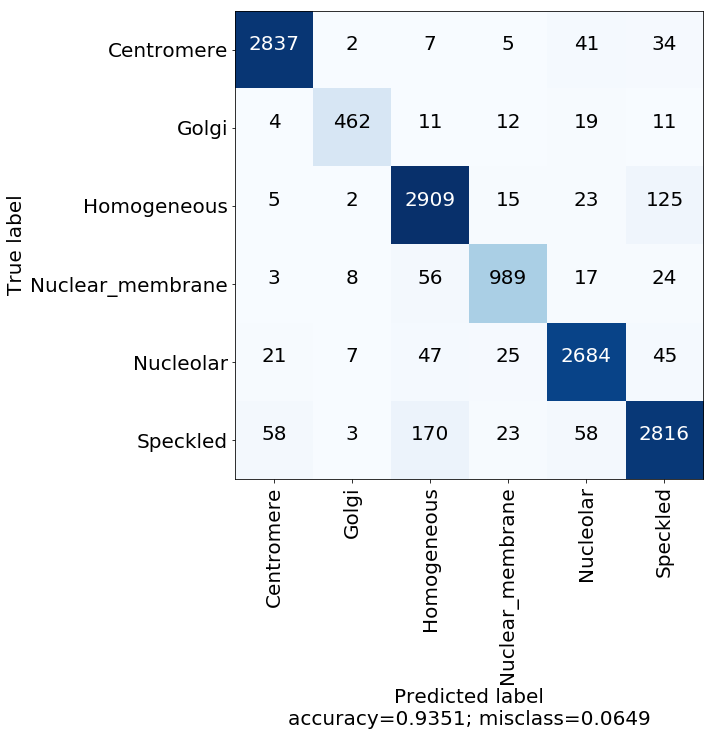

In [23]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[2837    2    7    5   41   34]
 [   4  462   11   12   19   11]
 [   5    2 2909   15   23  125]
 [   3    8   56  989   17   24]
 [  21    7   47   25 2684   45]
 [  58    3  170   23   58 2816]]
                  precision    recall  f1-score   support

      Centromere       0.97      0.97      0.97      2926
           Golgi       0.95      0.89      0.92       519
     Homogeneous       0.91      0.94      0.93      3079
Nuclear_membrane       0.93      0.90      0.91      1097
       Nucleolar       0.94      0.95      0.95      2829
        Speckled       0.92      0.90      0.91      3128

     avg / total       0.94      0.94      0.94     13578



In [25]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.9985920450545582
Specificity :  0.9956896551724138


In [26]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

13578/13578 [==============================] - 1s 42us/step
Precision =  0.9352917245134428
Recall =  0.935115628222124
f1_score =  0.9350400422823694


In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9590379090308343


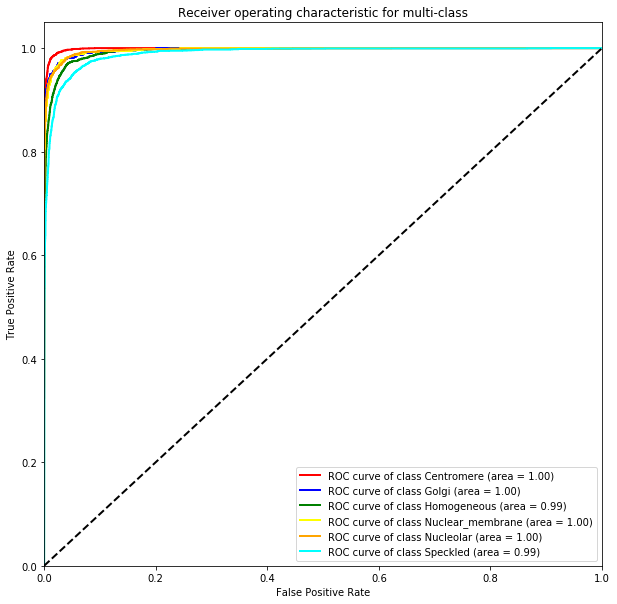

In [28]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

predict_class = np.argmax(preds, axis=1)

y_pred = preds
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4, 5])
y_pred_binary = y_pred_probabilities
n_classes=6
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

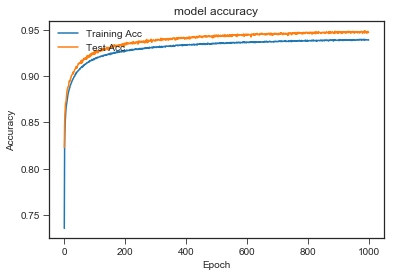

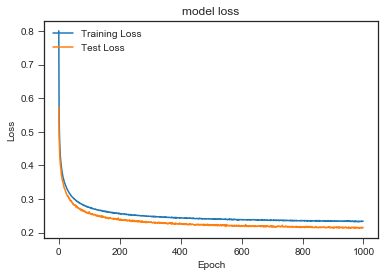

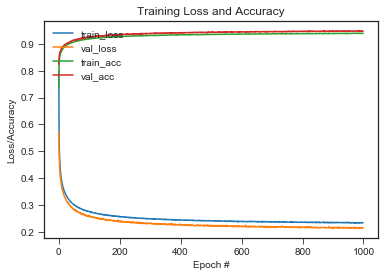

In [29]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")